In [1]:
import torch
import torch.nn as nn
import sys
import time
from typing import Union, List, Dict, Any, cast
from torch.nn import init
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm

For google collab purposes

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Go to this link for data: https://www.kaggle.com/datasets/samuelcortinhas/sports-balls-multiclass-image-classification, in my case zip is called archive, and folders within are train and test.

Change root to proper train and test folders

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


trainset = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/archive/train', transform=transform)
testset = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/archive/test', transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers = 12)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers = 12)

Model with attention

In [4]:
def vgg_block(num_convs, in_channels, num_channels):
    layers = []
    for _ in range(num_convs):
        layers += [nn.Conv2d(in_channels=in_channels, out_channels=num_channels, kernel_size=3, padding=1)]
        in_channels = num_channels
    layers += [nn.BatchNorm2d(num_channels), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)]
    return nn.Sequential(*layers)
class AttentionModule(nn.Module):
    def __init__(self, in_channels):
        super(AttentionModule, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 1, kernel_size=1)  # Convert to a single channel
        self.softmax = nn.Softmax(dim=-1)  # Apply softmax along a specified dimension


    def forward(self, x):
        att_weights = self.softmax(self.conv1(x).view(x.size(0), -1))  # Flatten, then apply softmax
        att_weights = att_weights.view(x.size(0), 1, x.size(2), x.size(3))  # Reshape back to 4D tensor
        return att_weights * x  # Apply attention weights to the original tensor


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_arch = ((2, 3, 64), (2, 64, 128), (2, 128, 256), (3, 256, 512), (3, 512, 512))
        layers = []


        for (num_convs, in_channels, num_channels) in self.conv_arch:
            layers += [vgg_block(num_convs, in_channels, num_channels)]


        self.features = nn.Sequential(*layers)

        self.attention = AttentionModule(512)







        self.dense1 = nn.Linear(512 * 7 * 7, 4096)
        self.drop1 = nn.Dropout(0.5)
        self.dense2 = nn.Linear(4096, 4096)
        self.drop2 = nn.Dropout(0.5)
        self.dense3 = nn.Linear(4096, 15)


    def forward(self, x):
        x = self.features(x)


        x = self.attention(x)


        x = x.view(-1, 512 * 7 * 7)  # Flatten before dense layers


        # Pass through the fully connected layers
        x = self.dense3(self.drop2(F.relu(self.dense2(self.drop1(F.relu(self.dense1(x)))))))
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = Net().to(device)
#optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(train_iter, test_iter, net, optimizer, device, num_epochs):
    net.to(device)
    print("training on", device)
    loss = nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        net.train()
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in tqdm(train_iter):
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]

        train_loss = train_l_sum / n
        train_accuracy = train_acc_sum / n


        val_accuracy = evaluate_accuracy(test_iter, net, device)
        print(f'Epoch {epoch + 1}, Loss: {train_loss}, Accuracy: {train_accuracy}, Val Accuracy: {val_accuracy}')

def evaluate_accuracy(data_iter, net, device):
    net.eval()
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in tqdm(data_iter):
            X, y = X.to(device), y.to(device)
            acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            n += y.shape[0]
    return acc_sum / n

In [5]:

num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net1 = Net()
#optimizer = optim.Adam(net1.parameters(), lr=0.001)
optimizer = torch.optim.SGD(net1.parameters(), lr=0.01, momentum=0.9)
train(trainloader, testloader, net1, optimizer, device, num_epochs)

training on cuda


  0%|          | 0/116 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 27/27 [02:59<00:00,  6.63s/it]


Epoch 1, Loss: 0.0418278285517915, Accuracy: 0.0986788891884605, Val Accuracy: 0.16666666666666666


100%|██████████| 27/27 [00:04<00:00,  6.38it/s]


Epoch 2, Loss: 0.03927667660351936, Accuracy: 0.17241844162847128, Val Accuracy: 0.17824074074074073


100%|██████████| 27/27 [00:04<00:00,  6.27it/s]


Epoch 3, Loss: 0.03773371158953657, Accuracy: 0.20908600700997573, Val Accuracy: 0.20543981481481483


100%|██████████| 27/27 [00:04<00:00,  5.70it/s]


Epoch 4, Loss: 0.03671939346018298, Accuracy: 0.23779994607710972, Val Accuracy: 0.22280092592592593


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]


Epoch 5, Loss: 0.035635370069129924, Accuracy: 0.25020221083850097, Val Accuracy: 0.2361111111111111


100%|██████████| 27/27 [00:04<00:00,  6.16it/s]


Epoch 6, Loss: 0.034637104536073486, Accuracy: 0.27756807764896196, Val Accuracy: 0.30266203703703703


100%|██████████| 27/27 [00:04<00:00,  5.96it/s]


Epoch 7, Loss: 0.0331989592636779, Accuracy: 0.312213534645457, Val Accuracy: 0.2991898148148148


100%|██████████| 27/27 [00:04<00:00,  6.24it/s]


Epoch 8, Loss: 0.03198278223481516, Accuracy: 0.343219196548935, Val Accuracy: 0.29976851851851855


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]


Epoch 9, Loss: 0.030687300350248862, Accuracy: 0.3661364249123753, Val Accuracy: 0.35300925925925924


100%|██████████| 27/27 [00:04<00:00,  5.82it/s]


Epoch 10, Loss: 0.029394955045613166, Accuracy: 0.40172553248854137, Val Accuracy: 0.36400462962962965


100%|██████████| 27/27 [00:04<00:00,  6.21it/s]


Epoch 11, Loss: 0.02845320109570242, Accuracy: 0.410218387705581, Val Accuracy: 0.37789351851851855


100%|██████████| 27/27 [00:04<00:00,  6.26it/s]


Epoch 12, Loss: 0.02725972434072425, Accuracy: 0.4362361822593691, Val Accuracy: 0.38483796296296297


100%|██████████| 27/27 [00:04<00:00,  5.94it/s]


Epoch 13, Loss: 0.02617875479983332, Accuracy: 0.4588837961714748, Val Accuracy: 0.3854166666666667


100%|██████████| 27/27 [00:04<00:00,  6.13it/s]


Epoch 14, Loss: 0.02554509168238163, Accuracy: 0.4816662173092478, Val Accuracy: 0.4230324074074074


100%|██████████| 27/27 [00:04<00:00,  6.28it/s]


Epoch 15, Loss: 0.024431237235291687, Accuracy: 0.49811269884065784, Val Accuracy: 0.4201388888888889


100%|██████████| 27/27 [00:04<00:00,  6.03it/s]


Epoch 16, Loss: 0.023168851693514125, Accuracy: 0.5319493124831491, Val Accuracy: 0.40914351851851855


100%|██████████| 27/27 [00:04<00:00,  6.27it/s]


Epoch 17, Loss: 0.021961567978165997, Accuracy: 0.5494742518198975, Val Accuracy: 0.44849537037037035


100%|██████████| 27/27 [00:04<00:00,  6.25it/s]


Epoch 18, Loss: 0.02100775385841458, Accuracy: 0.5684820706389863, Val Accuracy: 0.42476851851851855


100%|██████████| 27/27 [00:04<00:00,  5.91it/s]


Epoch 19, Loss: 0.01991082619836498, Accuracy: 0.5885683472634133, Val Accuracy: 0.39351851851851855


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]


Epoch 20, Loss: 0.018605122583257635, Accuracy: 0.6221353464545699, Val Accuracy: 0.4519675925925926


100%|██████████| 27/27 [00:04<00:00,  6.29it/s]


Epoch 21, Loss: 0.01780261175270574, Accuracy: 0.6327851172822864, Val Accuracy: 0.4195601851851852


100%|██████████| 27/27 [00:04<00:00,  6.06it/s]


Epoch 22, Loss: 0.01720655174164092, Accuracy: 0.6451873820436775, Val Accuracy: 0.4386574074074074


100%|██████████| 27/27 [00:04<00:00,  6.00it/s]


Epoch 23, Loss: 0.015885739249018333, Accuracy: 0.6779455378808305, Val Accuracy: 0.4988425925925926


100%|██████████| 27/27 [00:04<00:00,  6.15it/s]


Epoch 24, Loss: 0.015043608573094376, Accuracy: 0.6942572121865732, Val Accuracy: 0.5173611111111112


100%|██████████| 27/27 [00:04<00:00,  6.09it/s]


Epoch 25, Loss: 0.014439570105085479, Accuracy: 0.7008627662442707, Val Accuracy: 0.5023148148148148


100%|██████████| 27/27 [00:04<00:00,  6.02it/s]


Epoch 26, Loss: 0.013242719323849158, Accuracy: 0.728363440280399, Val Accuracy: 0.5428240740740741


100%|██████████| 27/27 [00:04<00:00,  6.25it/s]


Epoch 27, Loss: 0.012524047801680371, Accuracy: 0.7409005122674576, Val Accuracy: 0.5271990740740741


100%|██████████| 27/27 [00:04<00:00,  6.21it/s]


Epoch 28, Loss: 0.011114834963745041, Accuracy: 0.7723105958479375, Val Accuracy: 0.5758101851851852


100%|██████████| 27/27 [00:04<00:00,  5.92it/s]


Epoch 29, Loss: 0.010571356152678218, Accuracy: 0.7861957400916689, Val Accuracy: 0.5196759259259259


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]


Epoch 30, Loss: 0.009625185754106964, Accuracy: 0.7988676193043948, Val Accuracy: 0.5497685185185185


100%|██████████| 27/27 [00:04<00:00,  6.24it/s]


Epoch 31, Loss: 0.01000244611757211, Accuracy: 0.7972499325963872, Val Accuracy: 0.4664351851851852


100%|██████████| 27/27 [00:04<00:00,  6.01it/s]


Epoch 32, Loss: 0.008509181353498835, Accuracy: 0.8234025343758425, Val Accuracy: 0.5555555555555556


100%|██████████| 27/27 [00:04<00:00,  6.11it/s]


Epoch 33, Loss: 0.00785897888321541, Accuracy: 0.8383661364249124, Val Accuracy: 0.5804398148148148


100%|██████████| 27/27 [00:04<00:00,  6.07it/s]


Epoch 34, Loss: 0.006773228265182385, Accuracy: 0.8619574009166892, Val Accuracy: 0.5549768518518519


100%|██████████| 27/27 [00:04<00:00,  5.99it/s]


Epoch 35, Loss: 0.0068762367764519505, Accuracy: 0.8585872202750068, Val Accuracy: 0.5804398148148148


100%|██████████| 27/27 [00:04<00:00,  5.94it/s]


Epoch 36, Loss: 0.006210844223552009, Accuracy: 0.8722027500674037, Val Accuracy: 0.5329861111111112


100%|██████████| 27/27 [00:04<00:00,  6.12it/s]


Epoch 37, Loss: 0.005352451473305765, Accuracy: 0.8893232677271502, Val Accuracy: 0.5787037037037037


100%|██████████| 27/27 [00:04<00:00,  6.15it/s]


Epoch 38, Loss: 0.004342474824786347, Accuracy: 0.9133189538959289, Val Accuracy: 0.5694444444444444


100%|██████████| 27/27 [00:04<00:00,  5.92it/s]


Epoch 39, Loss: 0.0055781485194962566, Accuracy: 0.8854138581827986, Val Accuracy: 0.5729166666666666


100%|██████████| 27/27 [00:04<00:00,  6.21it/s]


Epoch 40, Loss: 0.0042250351234567425, Accuracy: 0.9149366406039364, Val Accuracy: 0.5729166666666666


100%|██████████| 27/27 [00:04<00:00,  6.22it/s]


Epoch 41, Loss: 0.003371131839167882, Accuracy: 0.9324615799406848, Val Accuracy: 0.6035879629629629


100%|██████████| 27/27 [00:04<00:00,  5.96it/s]


Epoch 42, Loss: 0.0030360540988294865, Accuracy: 0.9369102183877056, Val Accuracy: 0.6296296296296297


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]


Epoch 43, Loss: 0.0025506539023703533, Accuracy: 0.9503909409544351, Val Accuracy: 0.6035879629629629


100%|██████████| 27/27 [00:04<00:00,  6.08it/s]


Epoch 44, Loss: 0.002508702447116134, Accuracy: 0.9491776759234295, Val Accuracy: 0.5960648148148148


100%|██████████| 27/27 [00:04<00:00,  6.13it/s]


Epoch 45, Loss: 0.002811984289121149, Accuracy: 0.9451334591534106, Val Accuracy: 0.5978009259259259


100%|██████████| 27/27 [00:04<00:00,  6.02it/s]


Epoch 46, Loss: 0.0027275373800146707, Accuracy: 0.9444594230250741, Val Accuracy: 0.5625


100%|██████████| 27/27 [00:04<00:00,  6.25it/s]


Epoch 47, Loss: 0.0024230491157031567, Accuracy: 0.9543003504987867, Val Accuracy: 0.6012731481481481


100%|██████████| 27/27 [00:04<00:00,  6.24it/s]


Epoch 48, Loss: 0.0026802969576696016, Accuracy: 0.9439201941224049, Val Accuracy: 0.6047453703703703


100%|██████████| 27/27 [00:04<00:00,  5.91it/s]


Epoch 49, Loss: 0.0027803314197381635, Accuracy: 0.9448638447020761, Val Accuracy: 0.6215277777777778


100%|██████████| 27/27 [00:04<00:00,  6.09it/s]

Epoch 50, Loss: 0.0021194459164370003, Accuracy: 0.9561876516581289, Val Accuracy: 0.6313657407407407


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


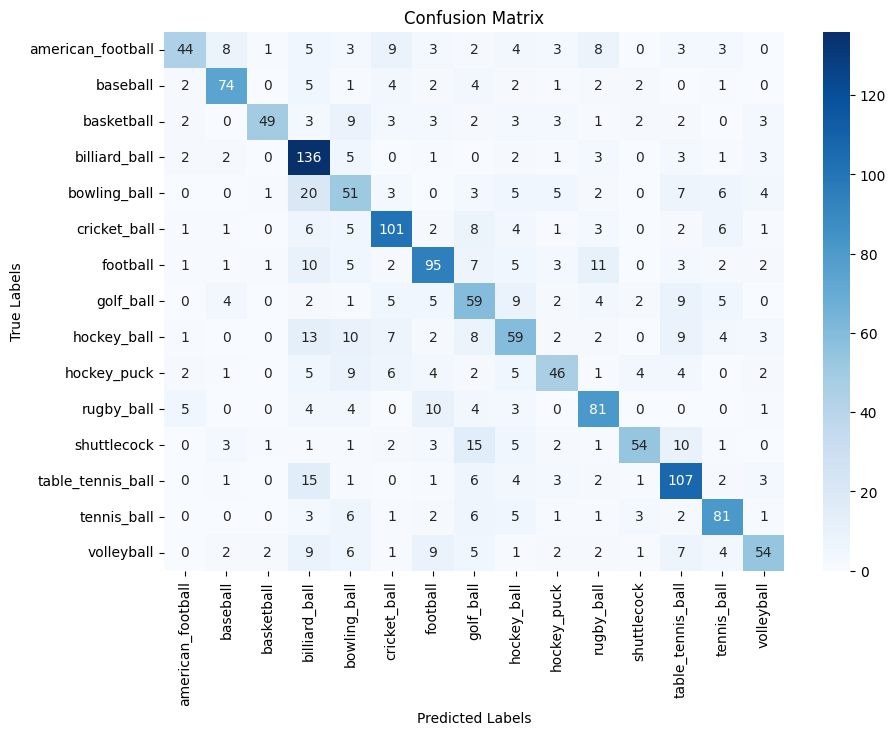

Accuracy: 0.6313657407407407


In [6]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.preprocessing import LabelEncoder


true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net1(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

class_names = testset.classes

label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(true_labels)
predicted_labels_encoded = label_encoder.transform(predicted_labels)

cm = confusion_matrix(true_labels_encoded, predicted_labels_encoded)

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm, class_names)

right = np.trace(cm)
other = np.sum(cm)
acc = right / other
print("Accuracy:", acc)


Original Model before attention

In [9]:
def vgg_block(num_convs, in_channels, num_channels):
    layers = []
    for _ in range(num_convs):
        layers += [nn.Conv2d(in_channels=in_channels, out_channels=num_channels, kernel_size=3, padding=1)]
        in_channels = num_channels
    layers += [nn.BatchNorm2d(num_channels), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)]
    return nn.Sequential(*layers)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_arch = ((2, 3, 64), (2, 64, 128), (2, 128, 256), (3, 256, 512), (3, 512, 512))
        layers = []
        for (num_convs, in_channels, num_channels) in self.conv_arch:
            layers += [vgg_block(num_convs, in_channels, num_channels)]
        self.features = nn.Sequential(*layers)
        self.dense1 = nn.Linear(512 * 7 * 7, 4096)



        self.drop1 = nn.Dropout(0.3)
        self.dense2 = nn.Linear(4096, 4096)
        self.drop2 = nn.Dropout(0.5)
        self.dense3 = nn.Linear(4096, 15)  # Change the number to match the number of your classes

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512 * 7 * 7)
        x = self.dense3(self.drop2(F.relu(self.dense2(self.drop1(F.relu(self.dense1(x)))))))
        return x

def train(train_iter, test_iter, net, optimizer, device, num_epochs):
    net.to(device)
    print("training on", device)
    loss = nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        net.train()
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in tqdm(train_iter):
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]

        train_loss = train_l_sum / n
        train_accuracy = train_acc_sum / n


        val_accuracy = evaluate_accuracy(test_iter, net, device)
        print(f'Epoch {epoch + 1}, Loss: {train_loss}, Accuracy: {train_accuracy}, Val Accuracy: {val_accuracy}')



def evaluate_accuracy(data_iter, net, device):
    net.eval()
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            n += y.shape[0]
    return acc_sum / n

In [31]:
num_epochs = 28
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net1 = Net()
#optimizer = optim.Adam(net1.parameters(), lr=0.001)
optimizer = torch.optim.SGD(net1.parameters(), lr=0.001, momentum=0.9)
train(trainloader, testloader, net1, optimizer, device, num_epochs)

training on cuda


  0%|          | 0/116 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 116/116 [00:17<00:00,  6.57it/s]


Epoch 1, Loss: 0.03819495428280227, Accuracy: 0.21110811539498517, Val Accuracy: 0.31712962962962965


100%|██████████| 116/116 [00:17<00:00,  6.53it/s]


Epoch 2, Loss: 0.032970599791983704, Accuracy: 0.3282555944998652, Val Accuracy: 0.3570601851851852


100%|██████████| 116/116 [00:17<00:00,  6.53it/s]


Epoch 3, Loss: 0.030152340724674574, Accuracy: 0.3820436775411162, Val Accuracy: 0.37962962962962965


100%|██████████| 116/116 [00:17<00:00,  6.56it/s]


Epoch 4, Loss: 0.027737383172016447, Accuracy: 0.43717983283904016, Val Accuracy: 0.3993055555555556


100%|██████████| 116/116 [00:17<00:00,  6.59it/s]


Epoch 5, Loss: 0.025579629110885006, Accuracy: 0.4780264222162308, Val Accuracy: 0.4722222222222222


100%|██████████| 116/116 [00:17<00:00,  6.45it/s]


Epoch 6, Loss: 0.023492191496098516, Accuracy: 0.5296575896468051, Val Accuracy: 0.4525462962962963


100%|██████████| 116/116 [00:17<00:00,  6.52it/s]


Epoch 7, Loss: 0.021562600656480087, Accuracy: 0.5718522512806686, Val Accuracy: 0.5104166666666666


100%|██████████| 116/116 [00:17<00:00,  6.49it/s]


Epoch 8, Loss: 0.019551807937676066, Accuracy: 0.610272310595848, Val Accuracy: 0.45891203703703703


100%|██████████| 116/116 [00:17<00:00,  6.58it/s]


Epoch 9, Loss: 0.017855933989177467, Accuracy: 0.6418172014019952, Val Accuracy: 0.5428240740740741


100%|██████████| 116/116 [00:17<00:00,  6.50it/s]


Epoch 10, Loss: 0.015110322369433824, Accuracy: 0.6976273928282556, Val Accuracy: 0.5422453703703703


100%|██████████| 116/116 [00:17<00:00,  6.51it/s]


Epoch 11, Loss: 0.013245725871160944, Accuracy: 0.7342949582097601, Val Accuracy: 0.5810185185185185


100%|██████████| 116/116 [00:17<00:00,  6.45it/s]


Epoch 12, Loss: 0.010957607986889106, Accuracy: 0.7860609328660016, Val Accuracy: 0.5601851851851852


100%|██████████| 116/116 [00:17<00:00,  6.53it/s]


Epoch 13, Loss: 0.008640808464864348, Accuracy: 0.8296036667565382, Val Accuracy: 0.6140046296296297


100%|██████████| 116/116 [00:17<00:00,  6.50it/s]


Epoch 14, Loss: 0.007162119017099878, Accuracy: 0.8571043407926665, Val Accuracy: 0.5943287037037037


100%|██████████| 116/116 [00:17<00:00,  6.54it/s]


Epoch 15, Loss: 0.005090379408023595, Accuracy: 0.9044216770018872, Val Accuracy: 0.6354166666666666


100%|██████████| 116/116 [00:17<00:00,  6.56it/s]


Epoch 16, Loss: 0.003974517572838909, Accuracy: 0.9277433270423294, Val Accuracy: 0.6296296296296297


100%|██████████| 116/116 [00:17<00:00,  6.45it/s]


Epoch 17, Loss: 0.0030923450898492585, Accuracy: 0.9423025074143974, Val Accuracy: 0.6608796296296297


100%|██████████| 116/116 [00:18<00:00,  6.44it/s]


Epoch 18, Loss: 0.0021108807300373885, Accuracy: 0.9634672418441629, Val Accuracy: 0.6510416666666666


100%|██████████| 116/116 [00:17<00:00,  6.55it/s]


Epoch 19, Loss: 0.0016302516805467564, Accuracy: 0.9746562415745484, Val Accuracy: 0.6533564814814815


100%|██████████| 116/116 [00:17<00:00,  6.50it/s]


Epoch 20, Loss: 0.0008566308777651783, Accuracy: 0.9902938797519547, Val Accuracy: 0.6695601851851852


100%|██████████| 116/116 [00:18<00:00,  6.43it/s]


Epoch 21, Loss: 0.0006068424648389594, Accuracy: 0.9929900242653006, Val Accuracy: 0.6915509259259259


100%|██████████| 116/116 [00:17<00:00,  6.47it/s]


Epoch 22, Loss: 0.000370454534548783, Accuracy: 0.9966298193583176, Val Accuracy: 0.6967592592592593


100%|██████████| 116/116 [00:17<00:00,  6.52it/s]


Epoch 23, Loss: 0.00046209175148202936, Accuracy: 0.9943380965219736, Val Accuracy: 0.6510416666666666


100%|██████████| 116/116 [00:17<00:00,  6.52it/s]


Epoch 24, Loss: 0.0004334091422936246, Accuracy: 0.9950121326503101, Val Accuracy: 0.6765046296296297


100%|██████████| 116/116 [00:18<00:00,  6.36it/s]


Epoch 25, Loss: 0.0003155542795698769, Accuracy: 0.9974386627123214, Val Accuracy: 0.7071759259259259


100%|██████████| 116/116 [00:17<00:00,  6.53it/s]


Epoch 26, Loss: 0.0001466774175985121, Accuracy: 0.999056349420329, Val Accuracy: 0.7135416666666666


100%|██████████| 116/116 [00:17<00:00,  6.58it/s]


Epoch 27, Loss: 0.0001108286450080921, Accuracy: 0.9997303855486654, Val Accuracy: 0.7129629629629629


100%|██████████| 116/116 [00:17<00:00,  6.48it/s]


Epoch 28, Loss: 0.00010809899583932472, Accuracy: 0.9991911566459962, Val Accuracy: 0.7106481481481481


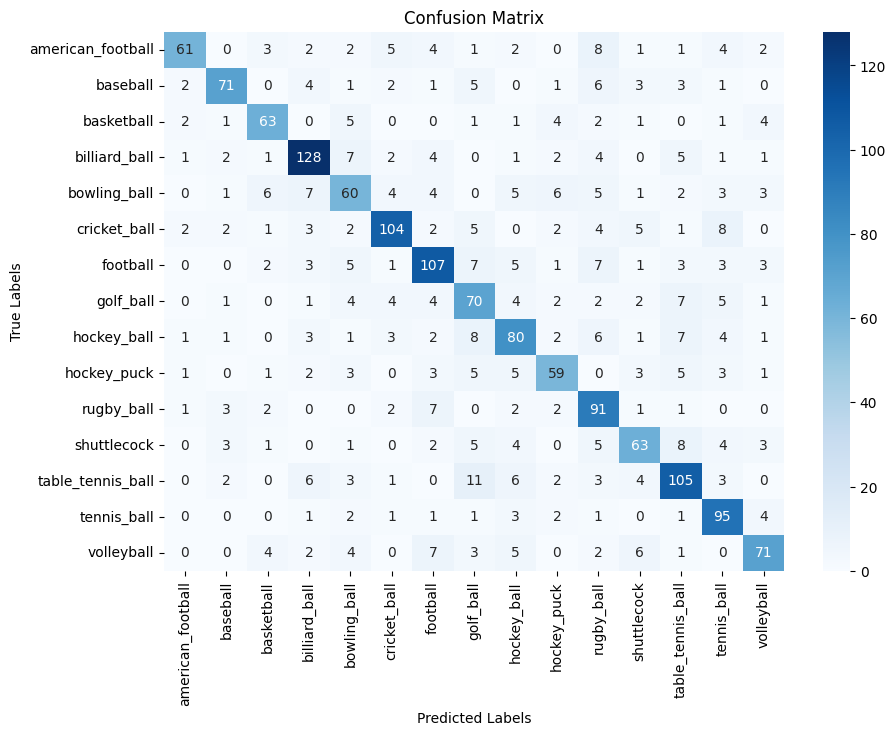

Accuracy: 0.7106481481481481


In [32]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.preprocessing import LabelEncoder


true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net1(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

class_names = testset.classes

label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(true_labels)
predicted_labels_encoded = label_encoder.transform(predicted_labels)

cm = confusion_matrix(true_labels_encoded, predicted_labels_encoded)

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm, class_names)

right = np.trace(cm)
other = np.sum(cm)
acc = right / other
print("Accuracy:", acc)
